## Imports

In [1]:
import os
import ast
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import torchvision.transforms as T
from skimage.transform import resize
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader

## Prepare forgery segmentation dataset

In [3]:
# Preprocessing: Convert bounding boxes to segmentation masks
def create_mask_from_bboxes(image_shape, annotations, num_classes):
    mask = Image.new('I', image_shape, 0)  # 'I' for integer mode
    draw = ImageDraw.Draw(mask)
    
#     # Example mapping, adjust according to your 'Entity type'
#     class_mapping = {'Forgery': 1}
    
    if annotations != 0:
        for ann in annotations["regions"]:
            bbox = ann['shape_attributes']
            draw.rectangle([bbox['x'], bbox['y'], bbox['x'] + bbox['width'], bbox['y'] + bbox['height']], fill=1)
    
    # Ensure the mask is in the correct format for training
    mask = np.array(mask)
    mask = np.clip(mask, 0, num_classes-1)  # Ensure mask values are within [0, num_classes-1]
    return mask

In [5]:
# Custom Dataset
class SegmentationDataset(Dataset):
    def __init__(self, image_dir, annotations, transform=None):
        self.image_dir = image_dir
        self.annotations = annotations
        self.transform = transform
        # Set a common size for all images and masks
        self.resize = transforms.Resize((256, 256))

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        ann = self.annotations.iloc[idx]
        image_path = os.path.join(self.image_dir, ann['image'])
        image = Image.open(image_path).convert('RGB')
        mask = create_mask_from_bboxes(image.size, ann["forgery annotations"], num_classes=2)
        
        if self.transform is not None:
            image = self.transform(image)
            mask = self.transform(mask)
        
        mask = np.array(mask, dtype=np.int64)  # Ensure mask is an integer type
        mask = torch.tensor(mask).squeeze(0)

        return image, mask

In [80]:
df = {}
for mode in ["train", "val", "test"]:
    df[mode] = pd.read_csv(f"./findit2/{mode}.txt")
    df[mode]["forgery annotations"] = df[mode]["forgery annotations"].map(ast.literal_eval)
    df[mode] = df[mode][df[mode]["image"].apply(lambda x: os.path.isfile(os.path.join(f"./findit2/{mode}", x)))]

In [82]:
df["test"]["forged"].sum()

35

## Instantiate PyTorch datasets and dataloaders

In [85]:
# Transform
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256, 256)),

])

# Example annotations list (your dataset)
annotations = df["train"]

# Initialize dataset
tr_dataset = SegmentationDataset("./findit2/train", df["train"], transform=transform)
va_dataset = SegmentationDataset("./findit2/val", df["val"], transform=transform)
te_dataset = SegmentationDataset("./findit2/test", df["test"], transform=transform)

tr_dataloader = DataLoader(tr_dataset, batch_size=4, shuffle=True, drop_last=True)
va_dataloader = DataLoader(va_dataset, batch_size=4, shuffle=True, drop_last=True)
te_dataloader = DataLoader(te_dataset, batch_size=4, shuffle=True, drop_last=True)

## Define model

In [28]:
# Model
model = models.segmentation.deeplabv3_mobilenet_v3_large(pretrained=False, num_classes=2)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


class_frequencies = [1.2, 1]  # Example frequencies for three classes

# Calculate weights
weights = 1.0 / torch.tensor(class_frequencies, dtype=torch.float32)


# Training essentials
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_function = torch.nn.CrossEntropyLoss(weight=weights)

/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


## Training model

In [31]:
# Training loop
tr_loss = []
va_loss = []
tr_iou = []
va_iou = []
num_epochs = 20  # Example, adjust as needed

def calculate_iou(preds, masks):
    intersection = (preds & masks).float().sum((1, 2))
    union = (preds | masks).float().sum((1, 2))
    iou = (intersection + 1e-6) / (union + 1e-6)
    return iou.mean().item()

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, masks in tqdm(tr_dataloader):
        images, masks = images.to(device), masks.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)['out']
        loss = loss_function(outputs, masks)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    tr_loss.append(running_loss / len(tr_dataloader))
    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, masks in va_dataloader:
            images, masks = images.to(device), masks.to(device)
            output = model(images)['out']
            loss = loss_function(output, masks)
            val_loss += loss.item()
    va_loss.append(val_loss / len(va_dataloader))
    print(f'Epoch {epoch+1}, Train Loss: {running_loss / len(tr_dataloader)}, Val Loss: {val_loss / len(va_dataloader)}')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [01:43<00:00,  1.39it/s]


Epoch 1, Train Loss: 0.28429362296851146, Val Loss: 0.07113109668716788


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [01:50<00:00,  1.31it/s]


Epoch 2, Train Loss: 0.05644738004128966, Val Loss: 0.038832525606267154


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [01:52<00:00,  1.28it/s]


Epoch 3, Train Loss: 0.03474767738953233, Val Loss: 0.028043562876215827


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [01:52<00:00,  1.29it/s]


Epoch 4, Train Loss: 0.025909360543462552, Val Loss: 0.022960021179945517


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [01:58<00:00,  1.22it/s]


Epoch 5, Train Loss: 0.021374295071129583, Val Loss: 0.020398222521180287


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [01:50<00:00,  1.31it/s]


Epoch 6, Train Loss: 0.01908336259334141, Val Loss: 0.019304938992718235


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [01:47<00:00,  1.35it/s]


Epoch 7, Train Loss: 0.01910628868629121, Val Loss: 0.018413334561046213


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [01:48<00:00,  1.33it/s]


Epoch 8, Train Loss: 0.018534729460952803, Val Loss: 0.055184870560575895


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [01:47<00:00,  1.34it/s]


Epoch 9, Train Loss: 0.016671505038781714, Val Loss: 0.01889926464355085


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [01:47<00:00,  1.34it/s]


Epoch 10, Train Loss: 0.017089170311616424, Val Loss: 0.017746592086041346


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [01:47<00:00,  1.34it/s]


Epoch 11, Train Loss: 0.01643348328070715, Val Loss: 0.017536077061474014


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [01:47<00:00,  1.35it/s]


Epoch 12, Train Loss: 0.015768596800626256, Val Loss: 0.01731699005419311


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [01:49<00:00,  1.32it/s]


Epoch 13, Train Loss: 0.013375214795814827, Val Loss: 0.01815013148492047


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [01:47<00:00,  1.34it/s]


Epoch 14, Train Loss: 0.014808705146101097, Val Loss: 0.017671797004974604


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [01:47<00:00,  1.34it/s]


Epoch 15, Train Loss: 0.015833178577142663, Val Loss: 0.017402008178275235


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [01:49<00:00,  1.32it/s]


Epoch 16, Train Loss: 0.016168629516161874, Val Loss: 0.023815957800252363


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [01:48<00:00,  1.33it/s]


Epoch 17, Train Loss: 0.01326724273773531, Val Loss: 0.017832102634808205


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [01:48<00:00,  1.33it/s]


Epoch 18, Train Loss: 0.012543184821778495, Val Loss: 0.02167153643434479


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [01:52<00:00,  1.28it/s]


Epoch 19, Train Loss: 0.012209326904364085, Val Loss: 0.017759682108589914


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [01:49<00:00,  1.31it/s]


Epoch 20, Train Loss: 0.010352799322895912, Val Loss: 0.019108819172591513


## Evaluating model performance

In [34]:
def compute_iou(pred, target, threshold):
    pred = (pred > threshold).float()
    intersection = torch.logical_and(pred, target).float().sum((1, 2))
    union = torch.logical_or(pred, target).float().sum((1, 2))
    iou = (intersection / union)
    return iou.mean().item()

# Test set evaluation
test_loss = 0.0
iou_scores_set = []
threshold_range = np.arange(0, 1.01, 0.01)
model.eval()
with torch.no_grad():
    for images, masks in tqdm(te_dataloader):
        images, masks = images.to(device), masks.to(device)
        output = model(images)['out']
        loss = loss_function(output, masks)
        test_loss += loss.item()
        iou_scores = []
        
        output = torch.sigmoid(output)[:, 1, :, :]  # Apply sigmoid to get probabilities and select forged class
        for threshold in threshold_range:
            iou = compute_iou(output, masks, threshold)
            iou_scores.append(iou)
        iou_scores_set.append(iou_scores)

avg_iou = np.mean(iou_scores_set, axis=0)

print(f'Test Loss: {test_loss / len(te_dataloader)}')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 54/54 [00:21<00:00,  2.49it/s]

Test Loss: 0.010867990414327424


### Plot train,validation and test losses

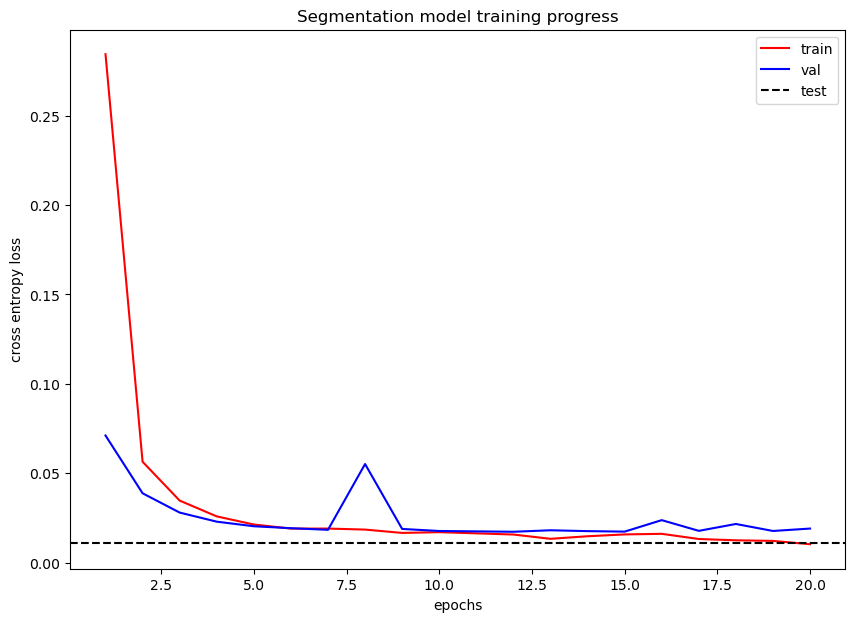

In [36]:
plt.figure(figsize=(10,7))
epochs = list(range(1, 21))
plt.plot(epochs, tr_loss, 'r', label='train')
plt.plot(epochs, va_loss, 'b', label='val')
plt.axhline(test_loss / len(te_dataloader), color='black', linestyle='--', label='test') 
plt.ylabel("cross entropy loss")
plt.xlabel("epochs")
plt.title("Segmentation model training progress")
plt.legend()

### Plot IoU on test set

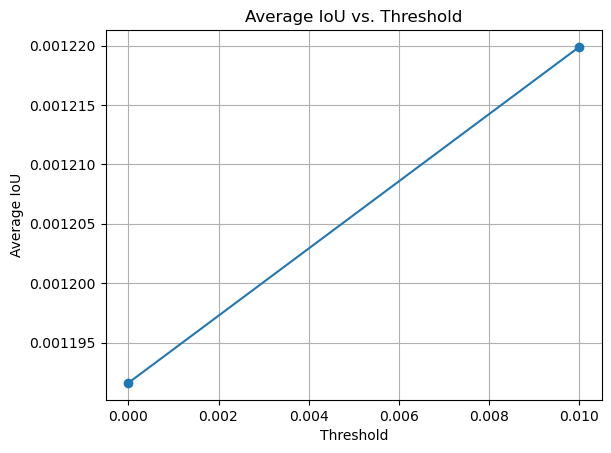

In [38]:
# Plotting the IoU curve
plt.plot(threshold_range, avg_iou, marker='o')
plt.xlabel('Threshold')
plt.ylabel('Average IoU')
plt.title('Average IoU vs. Threshold')
plt.grid(True)
plt.show()

## Interpreting model predictions

In [50]:
mode = "test"

transform = T.Compose([
    T.Resize((256, 256)),
    # Don't convert to tensor yet to facilitate visualization steps
])

image_path = f'./findit2/test/X51005568866.png'
## image_path = f'./findit2/torchdataset/test/1/X51005757243.png'
# image_path = f'./findit2/torchdataset/test/1/X51006557117.png'
# image_path = f'./findit2/torchdataset/test/1/X51006557195.png'

# Load the original image
original_image = Image.open(image_path).convert('RGB')
original_size = original_image.size  # Width, Height

# Apply the same transformations as during training (excluding ToTensor)
transformed_image = transform(original_image)  # Resized image

In [52]:
model.eval()  # Ensure the model is in evaluation mode
with torch.no_grad():
    input_tensor = T.functional.to_tensor(transformed_image).unsqueeze(0).to(device)  # Add batch dimension and transfer to GPU
    output = model(input_tensor)['out']
    predictions = torch.argmax(output.squeeze(), dim=0).detach().cpu().numpy()  # Convert to numpy array for visualization

In [60]:
predictions_prob = torch.softmax(output, dim=1)[0][1]
predictions_prob = np.array(predictions_prob, dtype=np.float32)

In [62]:
# Resize predictions back to the original image size
predictions_resized = resize(predictions_prob, (original_size[1], original_size[0]), 
                             order=0, preserve_range=True, anti_aliasing=False)


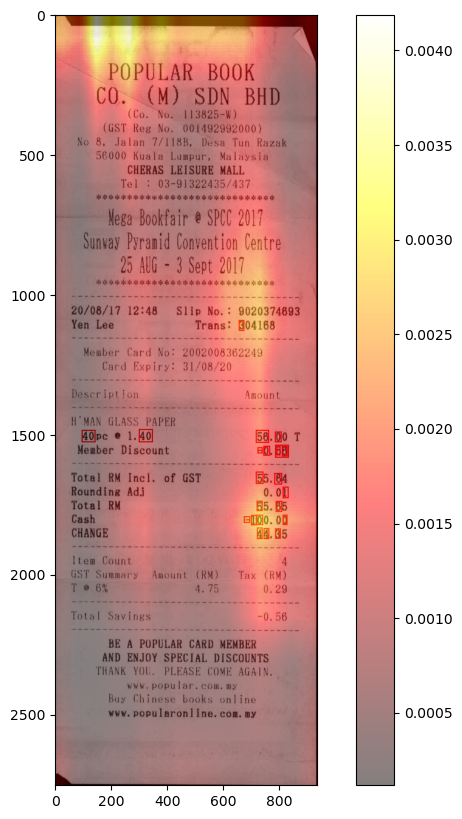

In [64]:
def draw_bounding_boxes(image, annotations):
    draw = ImageDraw.Draw(image)
    for ann in annotations['regions']:
        shape_attr = ann['shape_attributes']
        x, y, w, h = shape_attr['x'], shape_attr['y'], shape_attr['width'], shape_attr['height']
        draw.rectangle([(x, y), (x+w, y+h)], outline="red", width=4)
    return image

annotations = df[mode][df[mode]["image"]==image_path.split("/")[-1]]["forgery annotations"].iloc[0]

# Load the original image without resizing to maintain original dimensions for visualization
original_image = Image.open(image_path).convert('RGB')
drawn_image = draw_bounding_boxes(original_image, annotations)  # Assume 'annotations' is defined

# Convert drawn image to array for overlaying
import numpy as np
drawn_image_array = np.array(drawn_image)

# Create a figure to display the results
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
# Display original image
ax.imshow(drawn_image_array)
# Overlay heatmap (You may need to adjust the alpha for better visualization)
heatmap = ax.imshow(predictions_resized, cmap='hot', interpolation='nearest', alpha=0.5)
plt.colorbar(heatmap)
plt.show()